API TRYOUTS

In [2]:
#run that at the start if not already(local): .\.venv\Scripts\Activate.ps1

import pandas as pd
import io
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import ast
import re
import numpy as np


import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection, pipeline
from tqdm import tqdm
from transformers.image_utils import load_image
#from ultralytics import FastSAM
import requests
import os, shutil, tempfile
import cv2
import supervision as sv
from inference_sdk import InferenceConfiguration, InferenceHTTPClient
import random
import yaml
from ultralytics import YOLO

from pathlib import Path
from dotenv import load_dotenv

c:\Users\adiha\Desktop\GenAi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# first display of the initial dataset (image,label)
# label can be: 0 - 1 bedroom
#               1 - 2 bedrooms
df = pd.read_parquet(
    r'C:\Users\adiha\Desktop\GenAi\floor-plans-labels-0-1_cleaned.parquet', engine="fastparquet")
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x...,0
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0


In [3]:
# present info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   461 non-null    object
 1   label   461 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


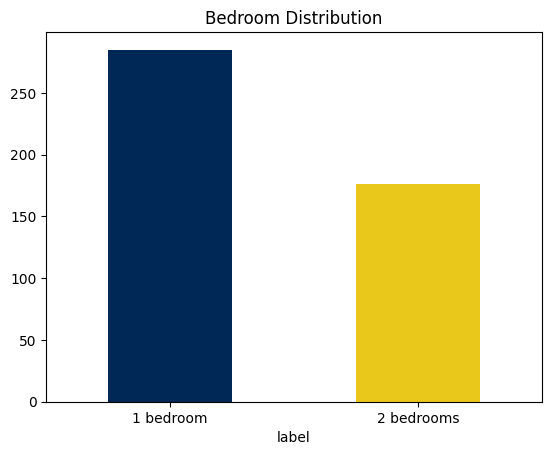

In [4]:

mycolors = ['#002856', '#EAC71B']
mytitles = ["1 bedroom", "2 bedrooms"]

counts = df['label'].value_counts().sort_index()
ax = counts.plot(kind='bar', color=mycolors, rot=0)
ax.set_xticklabels(mytitles)
ax.set_title("Bedroom Distribution")
plt.show()

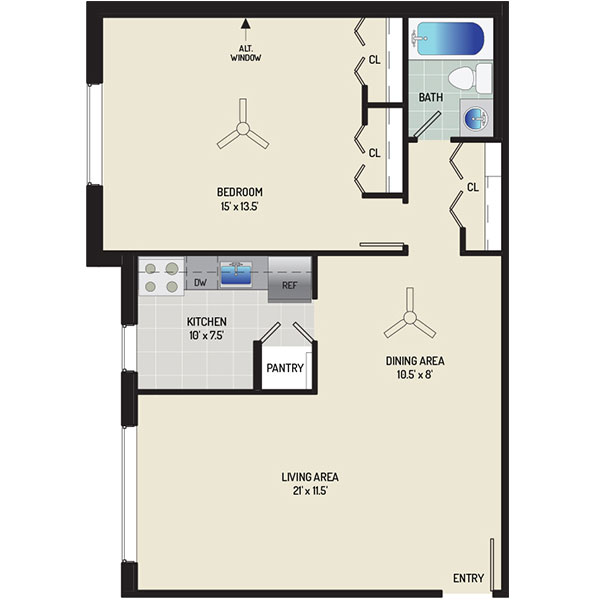

In [5]:
# extract the first image of
image_data_raw = df.iloc[0]['image']
image_data = ast.literal_eval(image_data_raw) # Convert string representation to actual dictionary

# Check if it's a dictionary or direct bytes
if isinstance(image_data, dict):
    img_bytes = image_data['bytes']
else:
    img_bytes = image_data

# View the first picture
img = Image.open(io.BytesIO(img_bytes))
display(img)

In [6]:
def convert_img_to_PilImage(image_entry):
  # If the entry is a string, convert it to an actual Python object (likely a dictionary)
  if isinstance(image_entry, str):
    image_entry = ast.literal_eval(image_entry)

  # Now, image_entry should be either a dictionary or direct bytes
  if isinstance(image_entry, dict):
    img_bytes = image_entry['bytes']
  else:
    img_bytes = image_entry # This case is for direct bytes if not wrapped in a dict

  img = Image.open(io.BytesIO(img_bytes))
  return img

# change all images to Pil image
# drop original image column
df['bw_image'] = df['image'].apply(convert_img_to_PilImage)
df.drop(columns=['image'], inplace=True)
df = df[['bw_image','label']]
df.head()
#############################################
#    all images type is Image.Image now     #
#############################################

,bw_image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0


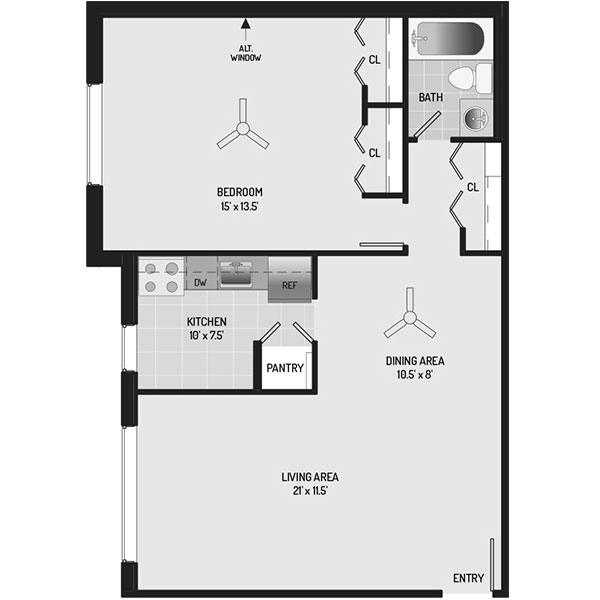

In [7]:
# Converting all the photos to black and white scale

def convert_to_bw(image_entry):
    """
    Reads the image data (bytes) and converts it to Black & White.
    """
    try:
        # Check if the entry is a Pil image
        if isinstance(image_entry, Image.Image):
           # Convert to Grayscale
           # 'L' = Grayscale (0-255 levels of gray) - Best for general use
           # '1' = Pure Black & White (No gray) - Best for sharp lines/blueprints
            img = image_entry.convert('L')
            return img
        else:
           print("img must be Image.Image type from Pil library")

    except Exception as e:
        print(f"Error: {e}")
        return None

# Apply the conversion to the whole column
# This creates a new column with the actual processed Image objects
df['bw_image'] = df['bw_image'].apply(convert_to_bw)
display(df['bw_image'][0])


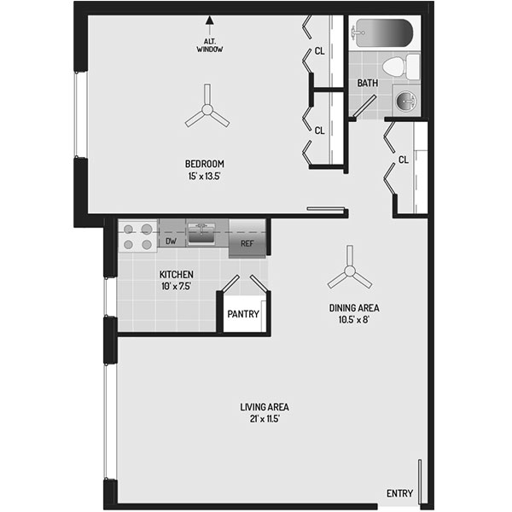

In [8]:
# Change all image sizes to 512x512
def change_img_size_to_512x512(image_entry):
  try:
   if isinstance(image_entry, Image.Image):
    img = image_entry.resize((512,512))
    return img
  except Exception as e:
    print(f"Error: {e}")
    return None

df['bw_image'] = df['bw_image'].apply(change_img_size_to_512x512)
display(df['bw_image'][0])

In [9]:
# changed all images to black and white(bw)
# resized all to 512x512
# rearranged columns for convenience
# dropped the original image column
df.head()

,bw_image,label
0,<PIL.Image.Image image mode=L size=512x512 at ...,0
1,<PIL.Image.Image image mode=L size=512x512 at ...,0
2,<PIL.Image.Image image mode=L size=512x512 at ...,0
3,<PIL.Image.Image image mode=L size=512x512 at ...,0
4,<PIL.Image.Image image mode=L size=512x512 at ...,0


In [10]:
import sys, torch
print("Python:", sys.executable)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Python: c:\Users\adiha\Desktop\GenAi\.venv\Scripts\python.exe
Torch: 2.5.1+cu121
CUDA available: True


In [11]:
import torch
print("Using:", torch.cuda.get_device_name(0))


Using: NVIDIA GeForce RTX 4060


In [12]:
# --- 1. CONFIGURATION ---

load_dotenv(Path.cwd() / ".env") # loads .env from current working dir

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

if not ROBOFLOW_API_KEY:
    raise ValueError("Missing ROBOFLOW_API_KEY. Put it in a .env file or environment variables.")

# Model to use for "Teacher" labeling (Auto-Labeling)
TEACHER_MODEL_ID = "floorplan-hskoj/1"

# Client setup
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key=ROBOFLOW_API_KEY
)

DATASET_DIR = "yolo_dataset_v1"

TARGET_CLASSES = {
    "sink": "sink",
    "large_sink": "sink",
    "small_sink": "sink",
    "twin_sink": "sink",
    "tub": "tub"
}

# --- 2. DATA PREPARATION FUNCTIONS ---

def convert_to_yolo_format(image_width, image_height, predictions, class_name_to_id):
    """
    Converts Roboflow API JSON response to YOLO .txt format
    with class filtering & merging, and contiguous class IDs.
    """
    lines = []
    preds_list = predictions.get('predictions', [])

    for pred in preds_list:
        raw_name = pred.get('class', 'unknown')

        # 1) Filter out unwanted classes
        if raw_name not in TARGET_CLASSES:
            continue

        # 2) Map to final (merged) class name
        final_name = TARGET_CLASSES[raw_name]

        # 3) Assign new contiguous ID
        if final_name not in class_name_to_id:
            class_name_to_id[final_name] = len(class_name_to_id)
        cls_id = class_name_to_id[final_name]

        # 4) Normalize bbox (x_center, y_center, w, h)
        x_center = pred['x'] / image_width
        y_center = pred['y'] / image_height
        w = pred['width'] / image_width
        h = pred['height'] / image_height

        lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    return lines


def prepare_dataset_from_df(df, output_dir):
    images_dir = os.path.join(output_dir, "train", "images")
    labels_dir = os.path.join(output_dir, "train", "labels")

    # Reset directory
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(images_dir)
    os.makedirs(labels_dir)

    print(f"Preparing dataset from {len(df)} images...")

    # final class name -> new id
    class_name_to_id = {}

    for index, row in df.iterrows():
        try:
            pil_image = row['bw_image']

            # Save temp file for API
            with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tf:
                pil_image.save(tf.name)
                temp_path = tf.name

            # API inference
            result = CLIENT.infer(temp_path, model_id=TEACHER_MODEL_ID)

            # Convert to YOLO (filtered)
            w, h = pil_image.size
            yolo_lines = convert_to_yolo_format(w, h, result, class_name_to_id)

            # Save Image
            img_filename = f"img_{index:04d}.jpg"
            pil_image.save(os.path.join(images_dir, img_filename))

            # Save Label (even if empty -> write empty file)
            txt_filename = f"img_{index:04d}.txt"
            with open(os.path.join(labels_dir, txt_filename), "w") as f:
                f.write("\n".join(yolo_lines))

            os.remove(temp_path)

            if index % 10 == 0:
                print(f"Processed row {index}...")

        except Exception as e:
            print(f"Skipping row {index}: {e}")

    # YOLO expects: id -> name mapping
    id_to_name = {v: k for k, v in class_name_to_id.items()}

    yaml_content = {
        'path': os.path.abspath(output_dir),
        'train': 'train/images',
        'val': 'train/images',
        'names': {k: id_to_name[k] for k in sorted(id_to_name)}
    }

    yaml_path = os.path.join(output_dir, "data.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_content, f, sort_keys=False)

    print(f"Dataset ready at {output_dir}")
    print(f"Classes: {yaml_content['names']}")
    return yaml_path


# --- 3. TRAINING FUNCTION ---

def train_fine_tuned_model(data_yaml_path):
    model = YOLO('yolov8n.pt')

    print("Starting Training...")

    results = model.train(
    data=data_yaml_path,
    epochs=30,

    imgsz=512,
    batch=2,
    device=0,

    workers=0, 
    cache=False,
    amp=False,

    freeze=10,

    mosaic=0.0,
    mixup=0.0,
    fliplr=0.5,
    flipud=0.0,
    scale=0.2,
    translate=0.05,
    degrees=0.0,

    optimizer='SGD',
    lr0=0.001,

    name='floorplan_icon_model_STABLE_V2'
)

    return results.save_dir


# --- 4. MAIN EXECUTION ---

if __name__ == "__main__":
    if 'df' in locals() and not df.empty:
        try:
            print("--- Step 1: Auto-Labeling Data ---")
            yaml_path = prepare_dataset_from_df(df.head(150), DATASET_DIR)

            print("\n--- Step 2: Training YOLO Model ---")
            save_dir = train_fine_tuned_model(yaml_path)

            print(f"\nSUCCESS! Model saved at: {save_dir}/weights/best.pt")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print("Error: DataFrame 'df' is missing or empty. Please load your data first.")

--- Step 1: Auto-Labeling Data ---
Preparing dataset from 150 images...
Processed row 0...
Processed row 10...
Processed row 20...
Processed row 30...
Processed row 40...
Processed row 50...
Processed row 60...
Processed row 70...
Processed row 80...
Processed row 90...
Processed row 100...
Processed row 110...
Processed row 120...
Processed row 130...
Processed row 140...
Dataset ready at yolo_dataset_v1
Classes: {0: 'sink', 1: 'tub'}

--- Step 2: Training YOLO Model ---
Starting Training...
New https://pypi.org/project/ultralytics/8.3.239 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.236  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset_v1\data.yaml, degree

Loading model from C:\Users\adiha\Desktop\GenAi\runs\detect\floorplan_icon_model_STABLE_V22\weights\best.pt...

image 1/1 C:\Users\adiha\Desktop\GenAi\testPlan2.PNG: 352x512 6 sinks, 3.4ms
Speed: 0.8ms preprocess, 3.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 512)


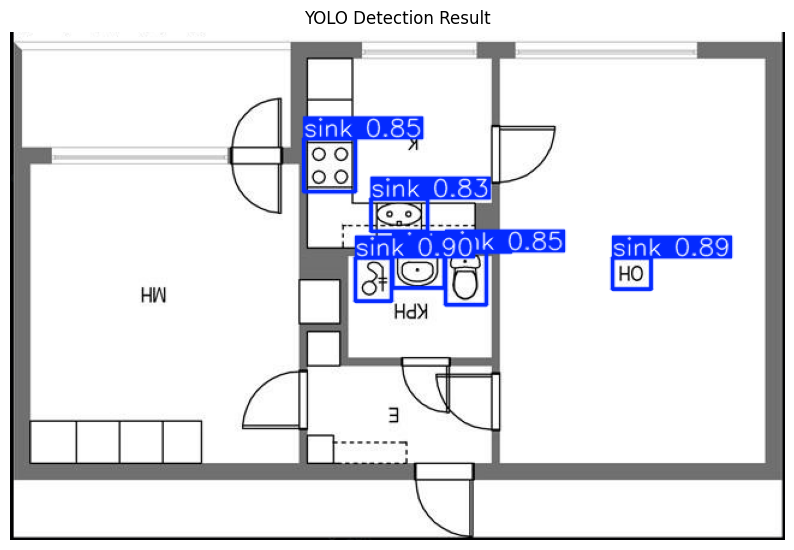

Prediction saved to prediction_output.jpg


In [4]:
def predict_new_floorplan(model_path, image_path):
    """
    Loads the trained model and predicts on a new image.
    """
    if not os.path.exists(model_path):
        print(f"Error: Model not found at {model_path}")
        return

    # Load the best model
    print(f"Loading model from {model_path}...")
    model = YOLO(model_path)

    # Run inference
    results = model.predict(image_path, conf=0.80, iou=0.3)

    # Visualize
    for result in results:
        # Plot result (returns numpy array in BGR)
        im_array = result.plot()

        # Convert BGR (OpenCV) to RGB (Matplotlib/PIL)
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

        # Display using Matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.title("YOLO Detection Result")
        plt.show()

        # Save to disk
        output_filename = "prediction_output.jpg"
        Image.fromarray(im_rgb).save(output_filename)
        print(f"Prediction saved to {output_filename}")

if __name__ == "__main__":
    # 1. Path to your trained weights (copied from your output log)
    best_weights = r"C:\Users\adiha\Desktop\GenAi\runs\detect\floorplan_icon_model_STABLE_V22\weights\best.pt"

    # 2. Path to a new image to test (make sure this file exists)
    test_image = r"C:\Users\adiha\Desktop\GenAi\testPlan2.PNG"

    if os.path.exists(test_image):
        predict_new_floorplan(best_weights, test_image)
    else:
        print(f"Please upload a test image to: {test_image}")